## analysis of favoring plaintiff vs favoring defendant

In [1]:
import causalml

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *




from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings



import os, sys
import numpy as np
import pandas as pd
import pickle
import time
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

pd.set_option('display.max_columns', None)


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.explore_utils as eu


In [5]:
df = pd.read_csv('/scratch/ns4486/cate_df.csv')

threshold_cate = 0.1

df['favors_plaintiff'] = np.ones(df.shape[0]) * -1
df['favors_plaintiff'][df['cate_X'] > threshold_cate] = 1
df['favors_plaintiff'][df['cate_X'] < -threshold_cate] = 0

df = df[df['favors_plaintiff'] != -1]


with open(r"/scratch/ns4486/cate_map_sample_50k.pkl", "rb") as input_file:
    cate_map = pickle.load(input_file)

In [6]:
df.shape

(5958, 2998)

In [7]:
df.columns

Index(['NOJ_1.0', 'NOJ_2.0', 'NOJ_3.0', 'NOJ_4.0', 'NOJ_5.0', 'NOJ_6.0',
       'NOJ_NA', 'PROSE_1.0', 'PROSE_2.0', 'PROSE_3.0',
       ...
       'district_year_93_nan', 'district_year_94_1988.0',
       'district_year_94_nan', 'y', 'treatment', 'treatment_shuffled',
       'cate_S', 'cate_X', 'cate_R', 'favors_plaintiff'],
      dtype='object', length=2998)

In [8]:
cate_map.keys()

dict_keys(['S', 'T', 'X', 'R'])

In [9]:
np.percentile(cate_map['X'][1], q = [0, 25, 50, 75, 100])

array([-1.27620265e+00, -1.46000303e-02,  1.01901399e-03,  2.40401742e-02,
        1.75250449e+00])

In [10]:
np.unique(np.digitize(cate_map['X'][1], [-2, -0.1, 0, 0.1, 2]), return_counts = True)

(array([1, 2, 3, 4]), array([ 2158, 22047, 21995,  3800]))

In [12]:
import re

def is_election_year(year):
    return year in list(range(1900, 2021, 4))

years = set()

# generate election year column
x = pd.Series([0] * df.shape[0])
for col in df.columns:
    if 'filing_year' in col:
        year = re.sub("[^0-9.]", "", col)
        if year is not None and year != '':
            year = int(float(year))
            
            if is_election_year(year):
                x += df[col]

df['is_filing_year_election_year'] = x


# keep case-level features only
case_features_original = [
    'NOJ',
#     'PROSE',
    'CLASSACT',
    'JURIS',
    'TRCLACT',
    'statuscd',
    'PROCPROG',
#     'CIRCUIT',
    'ORIGIN',
#     'office',
    'NOS',
#     'district',
    'DISP',
#     'filing_year',
#     'district_year'
]

case_features = []

df_case = df.copy()
df_case['treatment'] = 1 - df_case['treatment']
df_case = df_case.rename(columns = {'treatment' : 'is_republican'})

for case_feature in case_features_original:
    for feature in df.columns:
        if case_feature in feature:
            case_features.append(feature)

            
target_col = 'favors_plaintiff'
extra_cols = ['is_filing_year_election_year', 'is_republican'] + [target_col]
case_features = case_features + extra_cols
df_case = df_case[case_features]


clf_cols = case_features.copy()
clf_cols.remove(target_col)

In [13]:
import xgboost

model = xgboost.XGBClassifier()
model.fit(df_case[clf_cols], df_case[target_col])

[02:09:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
x = sorted(list(zip(clf_cols, list(model.feature_importances_))), key = lambda x: -x[1])
feature_imp_df = pd.DataFrame(x, columns = ['feature', 'importance'])
feature_imp_df = feature_imp_df.sort_values(by = ['importance'], ascending = False)
x = dict(x)

In [15]:
import json

with open('/scratch/ns4486/case_metadata.json') as f:
    case_meta_map = json.load(f)

In [16]:
case_meta_map['NOS']

{'110': 'INSURANCE',
 '120': 'MARINE CONTRACT ACTIONS',
 '130': 'MILLER ACT',
 '140': 'NEGOTIABLE INSTRUMENTS',
 '150': 'OVERPAYMENTS & ENFORCEMENT OF JUDGMENTS',
 '151': 'OVERPAYMENTS UNDER THE MEDICARE ACT',
 '152': 'RECOVERY OF DEFAULTED STUDENT LOANS',
 '153': 'RECOVERY OF OVERPAYMENTS OF VET BENEFITS',
 '160': "STOCKHOLDER'S SUITS",
 '190': 'OTHER CONTRACT ACTIONS',
 '195': 'CONTRACT PRODUCT LIABILITY',
 '196': 'CONTRACT FRANCHISE',
 '210': 'LAND CONDEMNATION',
 '220': 'FORECLOSURE',
 '230': 'RENT, LEASE, EJECTMENT',
 '240': 'TORTS TO LAND',
 '245': 'TORT PRODUCT LIABILITY',
 '290': 'OTHER REAL PROPERTY ACTIONS',
 '310': 'AIRPLANE PERSONAL INJURY',
 '315': 'AIRPLANE PRODUCT LIABILITY',
 '320': 'ASSAULT, LIBEL, AND SLANDER',
 '330': "FEDERAL EMPLOYERS' LIABILITY",
 '340': 'MARINE PERSONAL INJURY',
 '345': 'MARINE - PRODUCT LIABILITY',
 '350': 'MOTOR VEHICLE PERSONAL INJURY',
 '355': 'MOTOR VEHICLE PRODUCT LIABILITY',
 '360': 'OTHER PERSONAL INJURY',
 '362': 'MEDICAL MALPRACTICE',
 

In [17]:
col_desc = []

for col in list(feature_imp_df['feature']):
    if col in ['is_filing_year_election_year', 'is_republican']:
        col_desc.append(col)
        continue
    
    if 'CLASSACT' in col:
        col_desc.append(col)
        continue
    
    cat_col = col.split('_')[0]
    cat_val = col.split('_')[1]
    
    if any(letter.isalpha() for letter in cat_val):
        col_desc.append(col)
    else:
        cat_val = str(int(float(cat_val)))
        
        if cat_val not in case_meta_map[cat_col].keys():
            desc = cat_val + '_undefined undefined undefined'
        else:
            desc = case_meta_map[cat_col][cat_val]
        col_desc.append(cat_col + '_' + desc)

feature_imp_df['desc'] = pd.Series(col_desc)

In [18]:
df_case_renamed = df_case.rename(columns = dict(list(feature_imp_df[['feature', 'desc']].to_records(index = False))))

<AxesSubplot:xlabel='importance', ylabel='desc'>

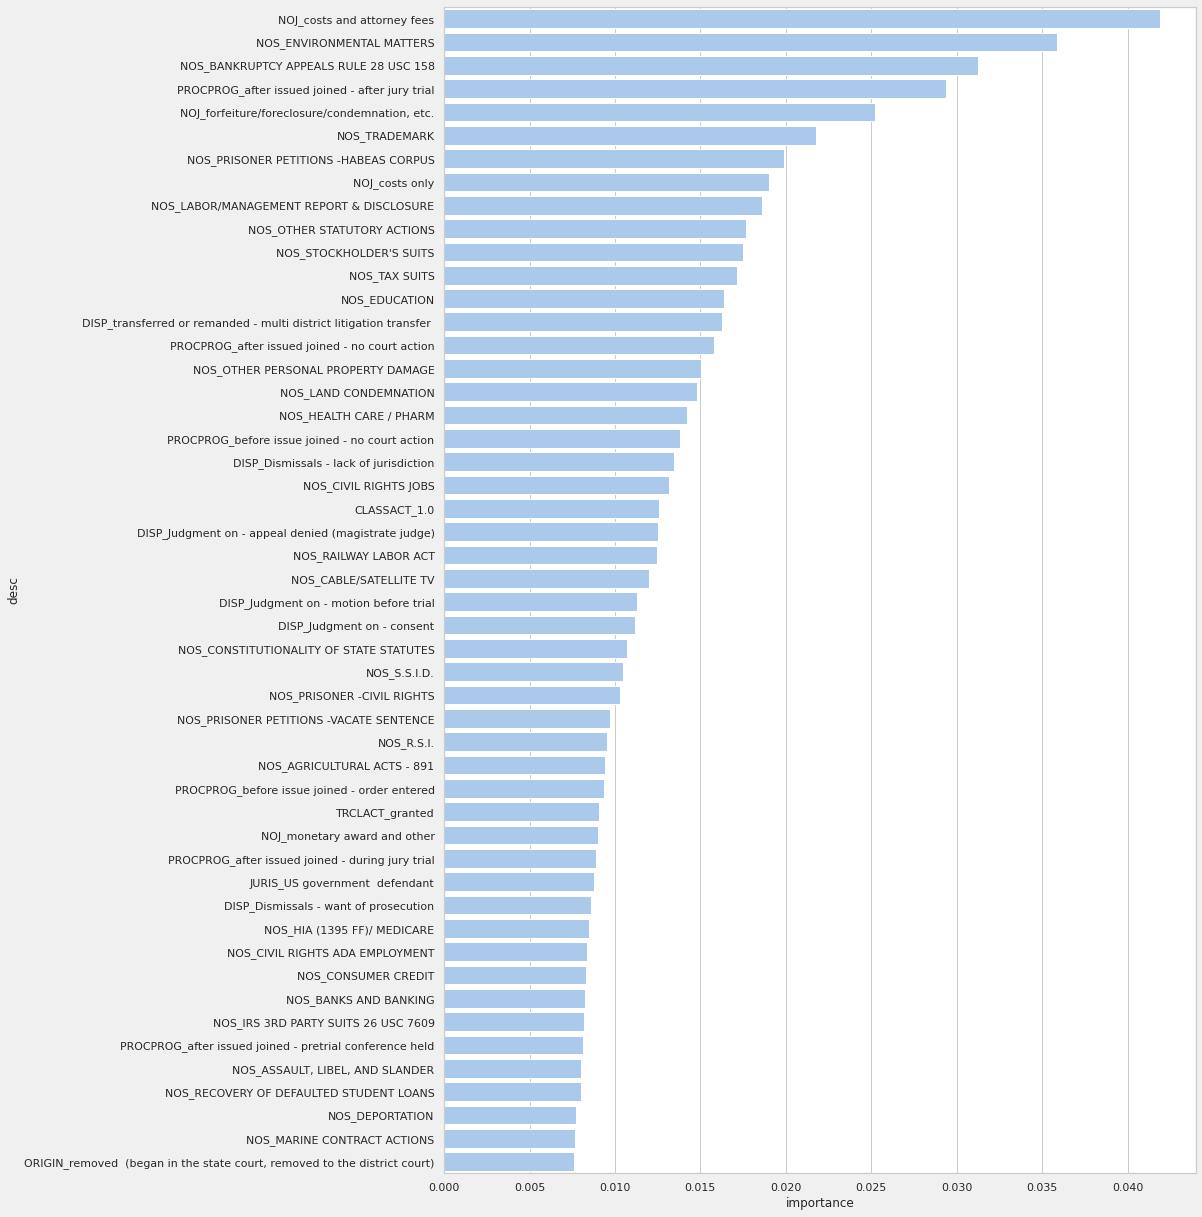

In [19]:
import seaborn as sns

plt.figure(figsize = (12, 20))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

sns.barplot(
    x="importance", 
    y="desc", 
    data=feature_imp_df.head(50),
    label="importance", 
    color="b"
)

In [20]:
import shap

renamed_cols = list(feature_imp_df['desc'])

bg = shap.maskers.Independent(df_case_renamed[renamed_cols], max_samples=100)
explainer = shap.Explainer(model, bg)

shap_values = explainer(df_case_renamed[renamed_cols])

In [21]:
z = set()
for k in renamed_cols:
    if k in z:
        print(k)
    else:
        z.add(k)

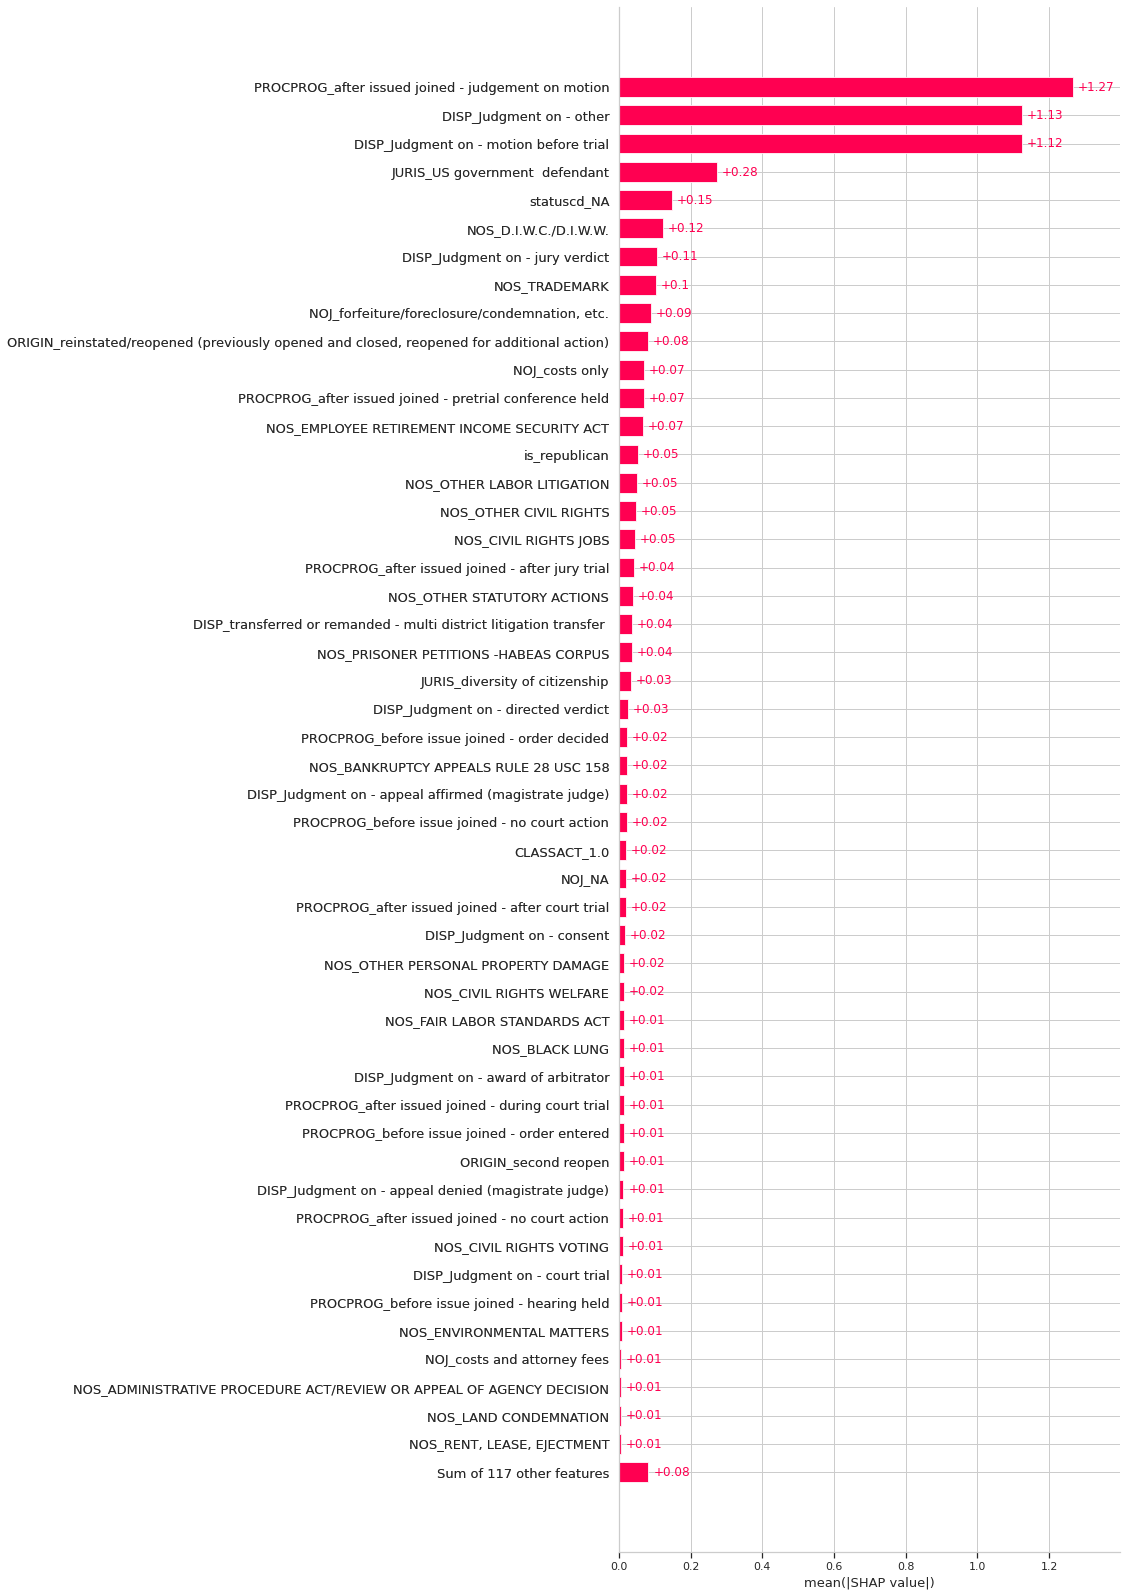

In [22]:
shap.plots.bar(shap_values, max_display = 50)

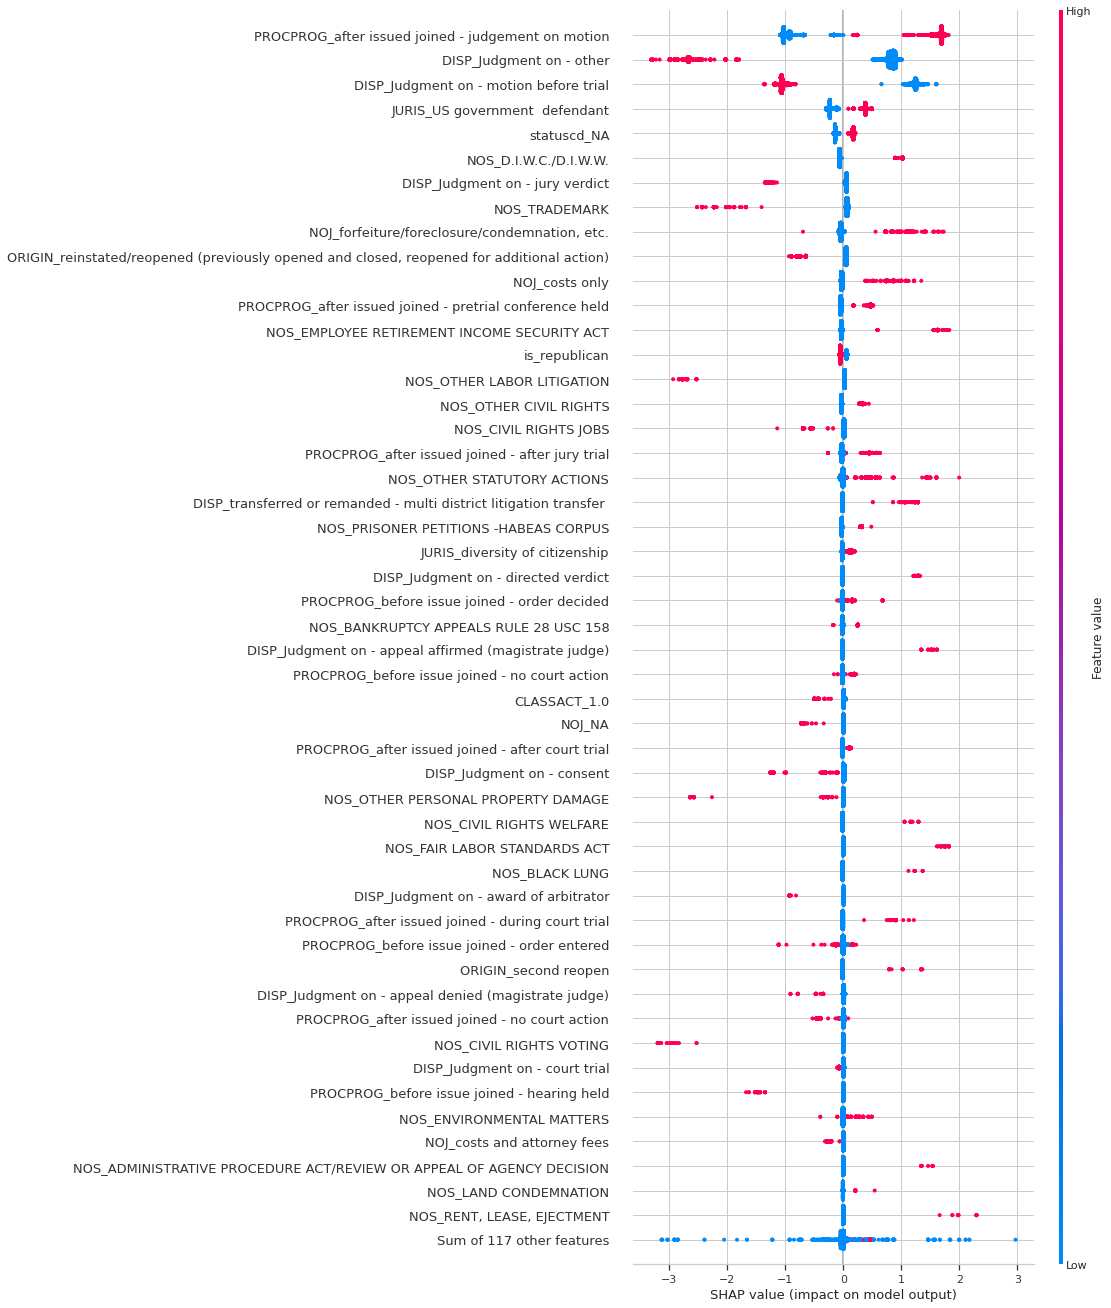

In [23]:
shap.plots.beeswarm(shap_values, max_display = 50)


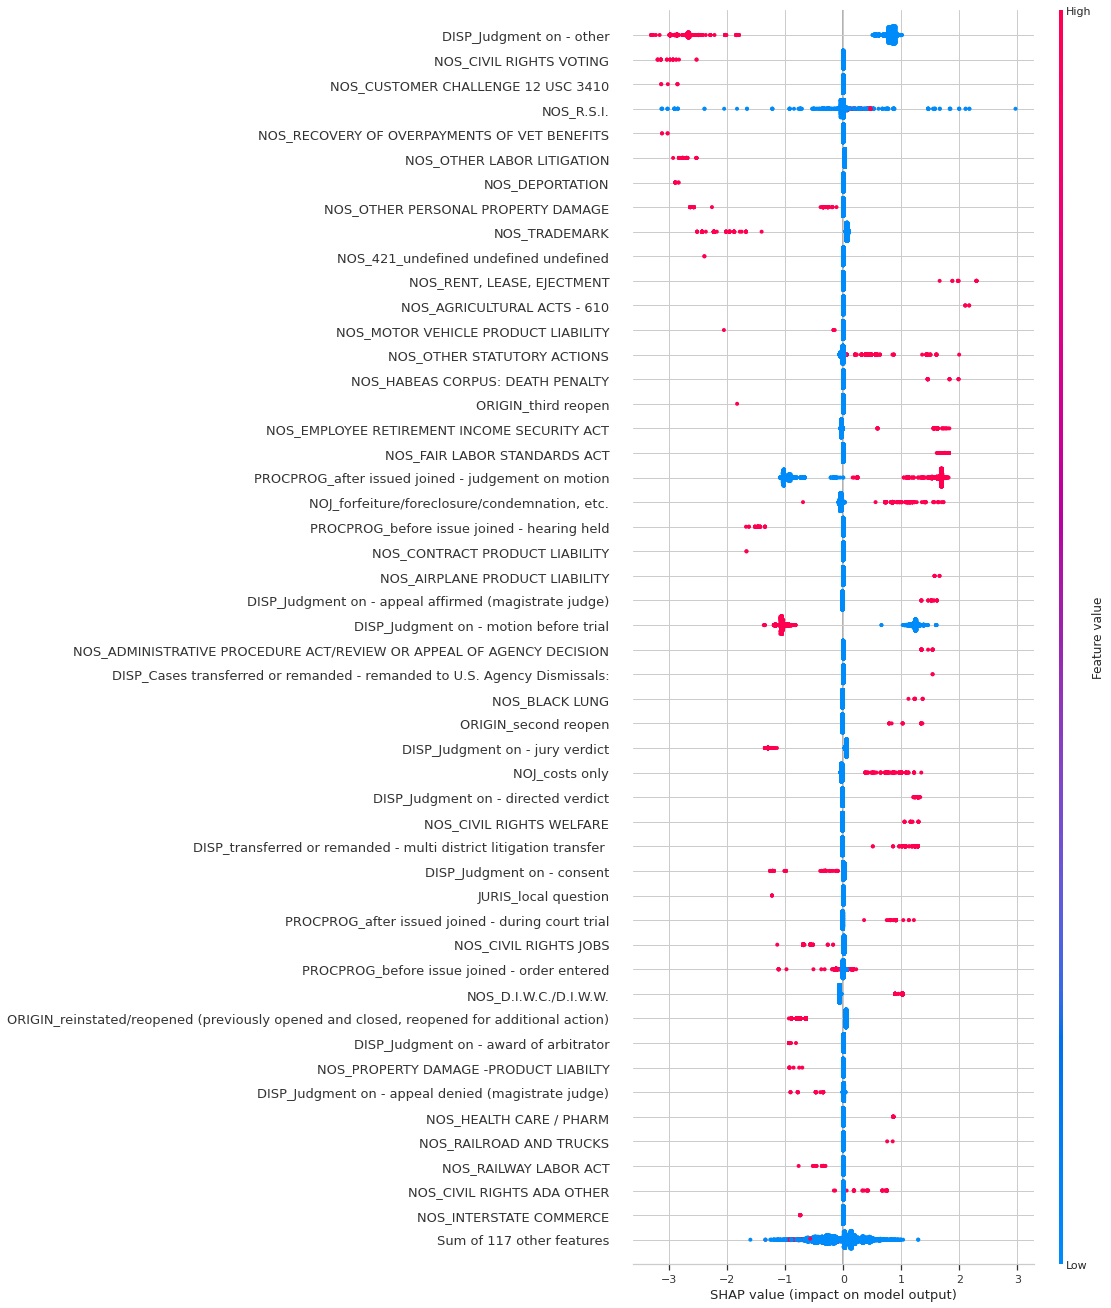

In [24]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display = 50)


In [166]:
df_case_renamed.columns

Index(['NOJ_monetary award only', 'NOJ_monetary award and other',
       'NOJ_injunction', 'NOJ_forfeiture/foreclosure/condemnation, etc.',
       'NOJ_costs only', 'NOJ_costs and attorney fees', 'NOJ_NA',
       'CLASSACT_1.0', 'JURIS_US government  defendant',
       'JURIS_federal question',
       ...
       'DISP_Dismissals - lack of jurisdiction', 'DISP_Judgment on - default',
       'DISP_Judgment on - consent', 'DISP_Judgment on - motion before trial',
       'DISP_Judgment on - jury verdict',
       'DISP_Judgment on - directed verdict', 'DISP_Judgment on - court trial',
       'is_filing_year_election_year', 'is_republican', 'favors_plaintiff'],
      dtype='object', length=167)

In [25]:
pd.crosstab(df_case_renamed['is_republican'], df_case_renamed['favors_plaintiff'])

favors_plaintiff,0.0,1.0
is_republican,,
0.0,990,1605
1.0,1168,2195


In [46]:
df_case_renamed['plaintiff_vs_defendant'] = np.ones(df_case_renamed.shape[0]) * -1
df_case_renamed['plaintiff_vs_defendant'][(df_case_renamed['is_republican'] == 1) & (df_case_renamed['favors_plaintiff'] == 1)] = 1
df_case_renamed['plaintiff_vs_defendant'][(df_case_renamed['is_republican'] == 0) & (df_case_renamed['favors_plaintiff'] == 0)] = 0

df_case_renamed = df_case_renamed[df_case_renamed['plaintiff_vs_defendant'] != -1]

In [47]:
segment_analysis_cols = renamed_cols.copy()
segment_analysis_cols.remove('is_republican')

ValueError: list.remove(x): x not in list

In [49]:
model = xgboost.XGBClassifier()
model.fit(df_case_renamed[segment_analysis_cols], df_case_renamed['plaintiff_vs_defendant'])

[02:33:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
x = sorted(list(zip(segment_analysis_cols, list(model.feature_importances_))), key = lambda x: -x[1])
feature_imp_df_1 = pd.DataFrame(x, columns = ['feature', 'importance'])
feature_imp_df_1 = feature_imp_df_1.sort_values(by = ['importance'], ascending = False)
x = dict(x)

<AxesSubplot:xlabel='importance', ylabel='feature'>

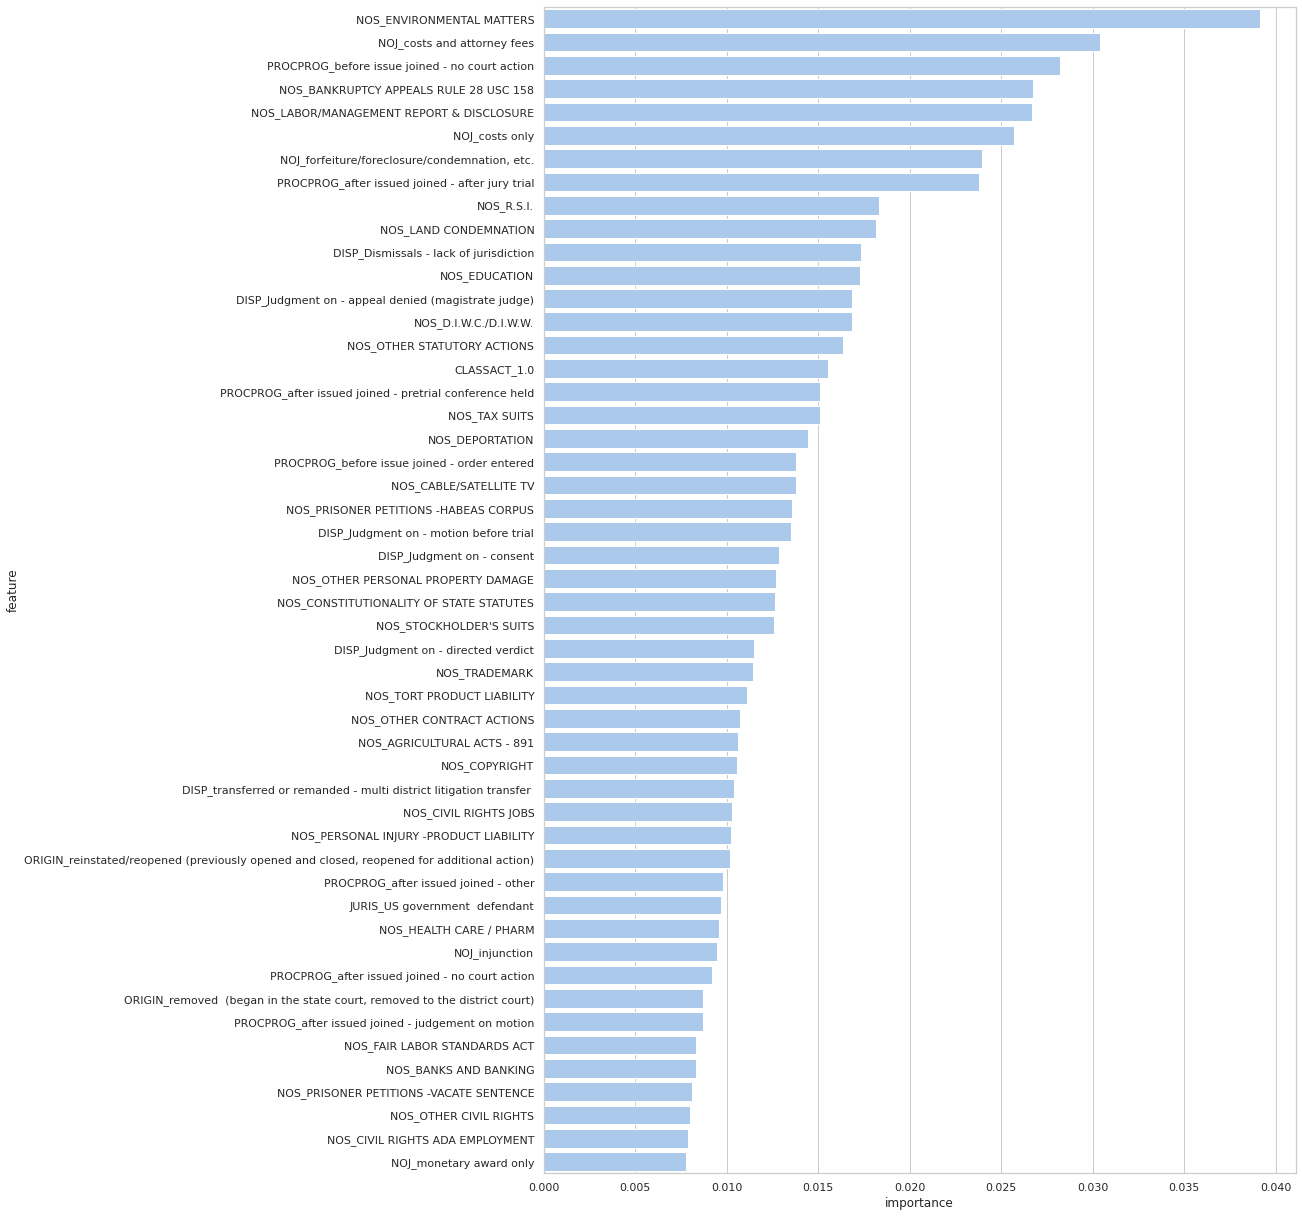

In [51]:
import seaborn as sns

plt.figure(figsize = (12, 20))

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

sns.barplot(
    x="importance", 
    y="feature", 
    data=feature_imp_df_1.head(50),
    label="importance", 
    color="b"
)

In [52]:
import shap

renamed_cols = list(feature_imp_df_1['feature'])

bg = shap.maskers.Independent(df_case_renamed[segment_analysis_cols], max_samples=100)
explainer = shap.Explainer(model, bg)

shap_values = explainer(df_case_renamed[segment_analysis_cols])

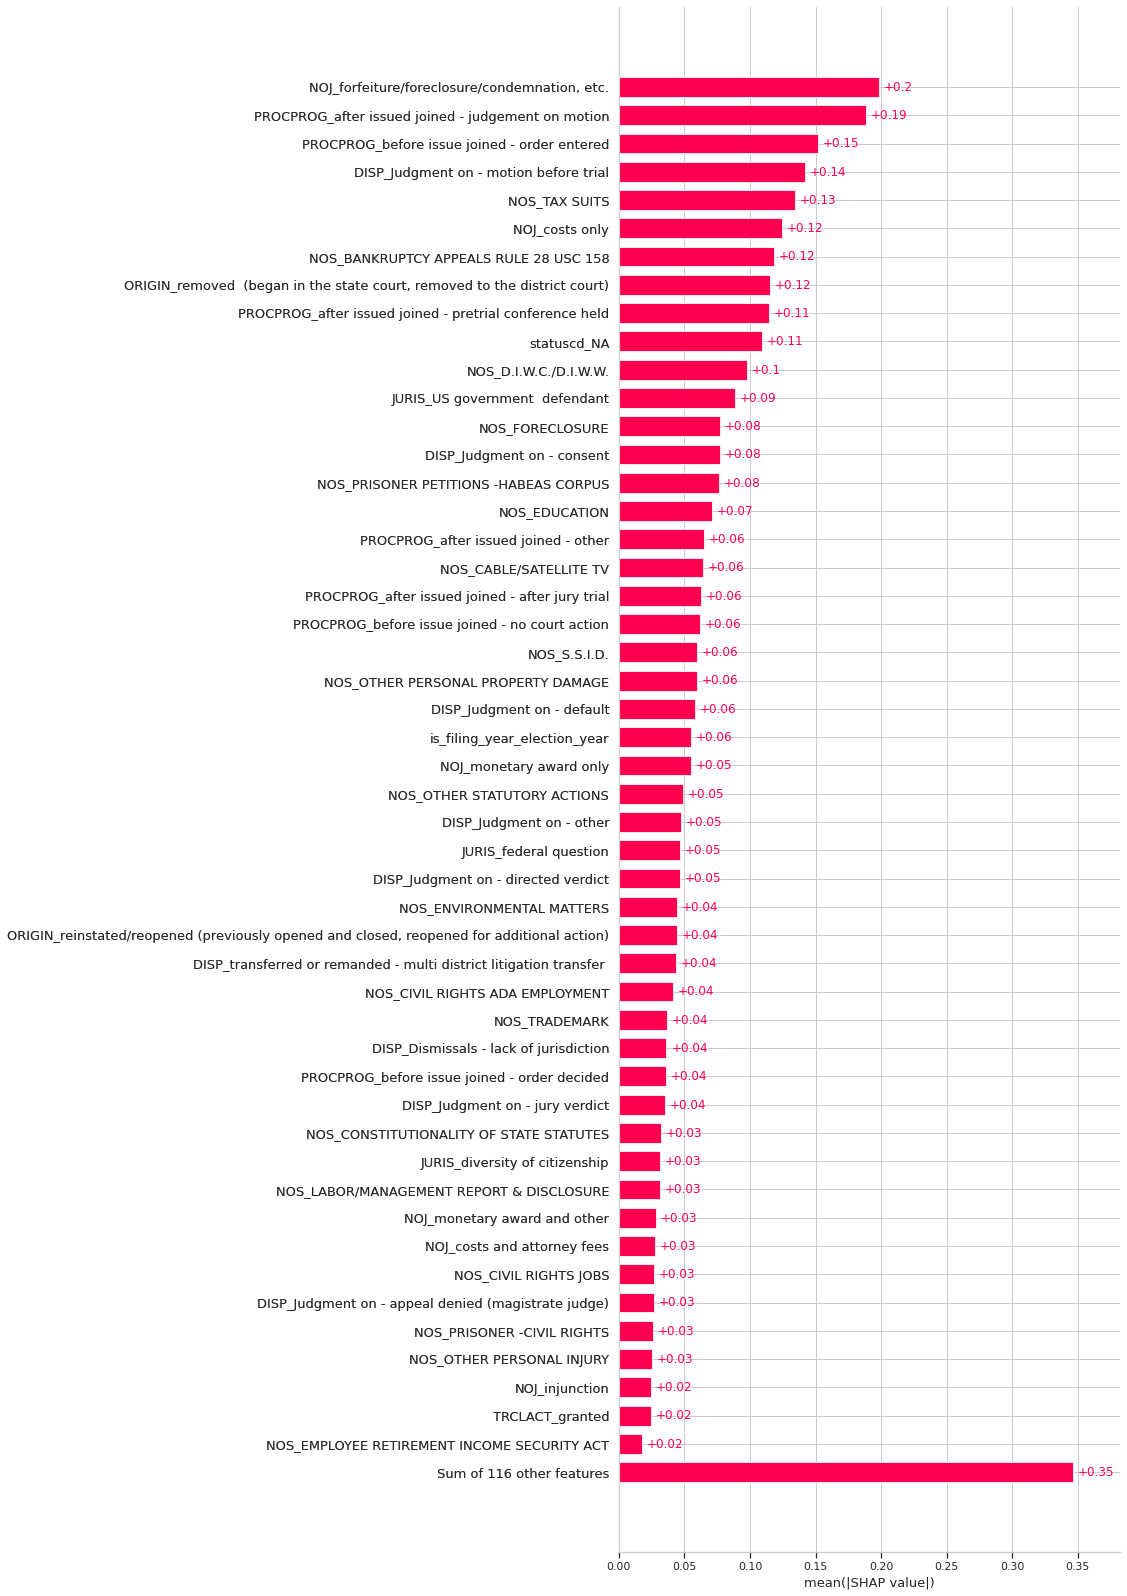

In [53]:
shap.plots.bar(shap_values, max_display = 50)

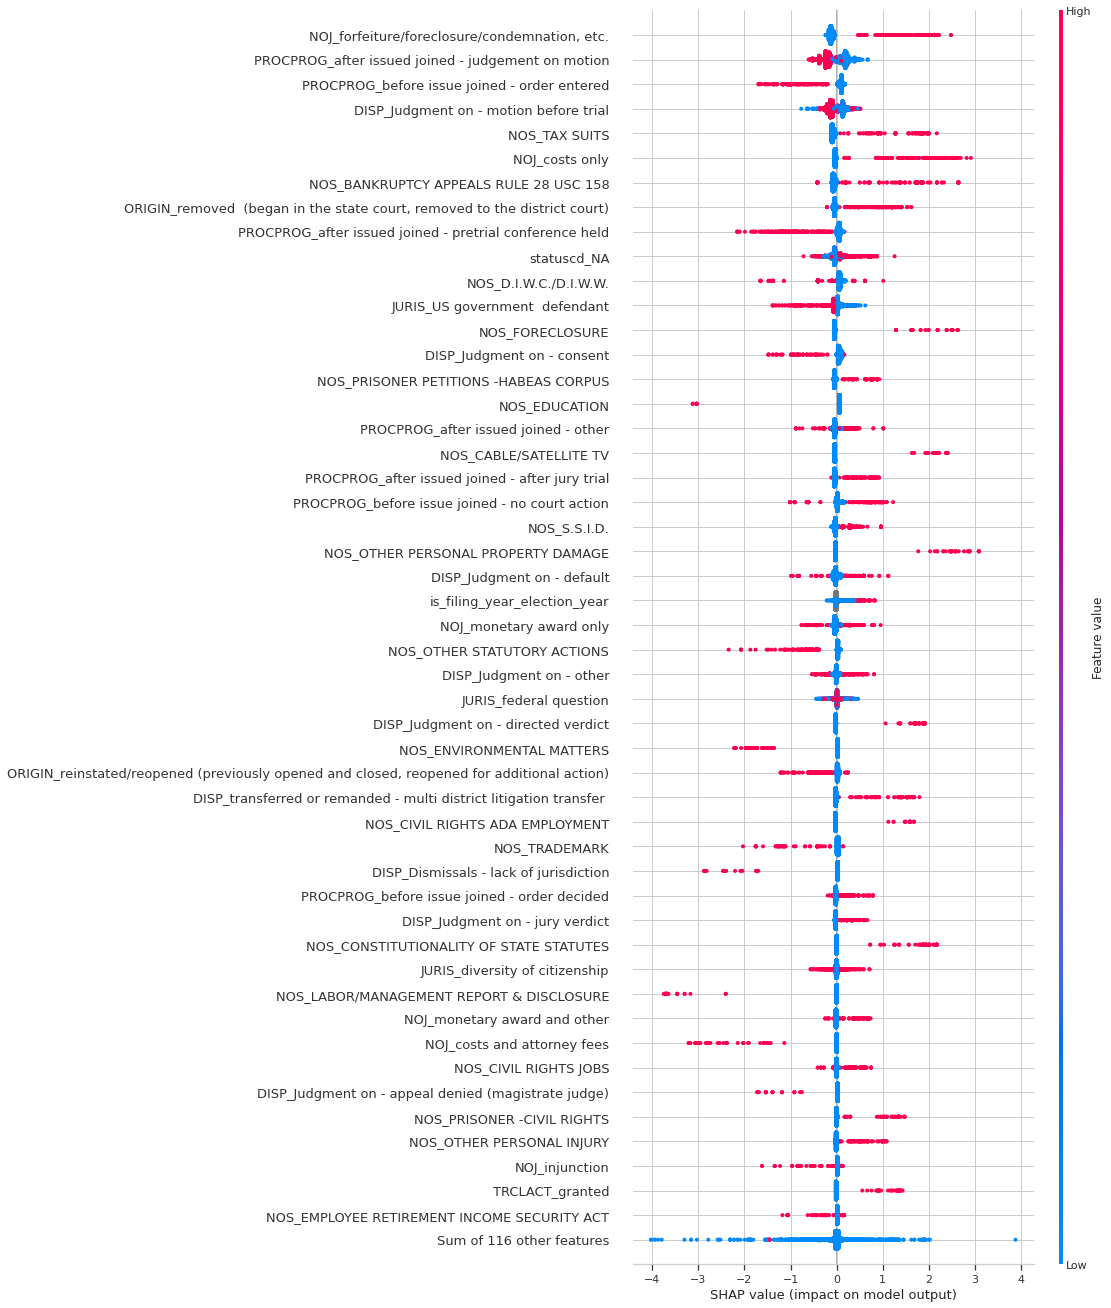

In [54]:
shap.plots.beeswarm(shap_values, max_display = 50)

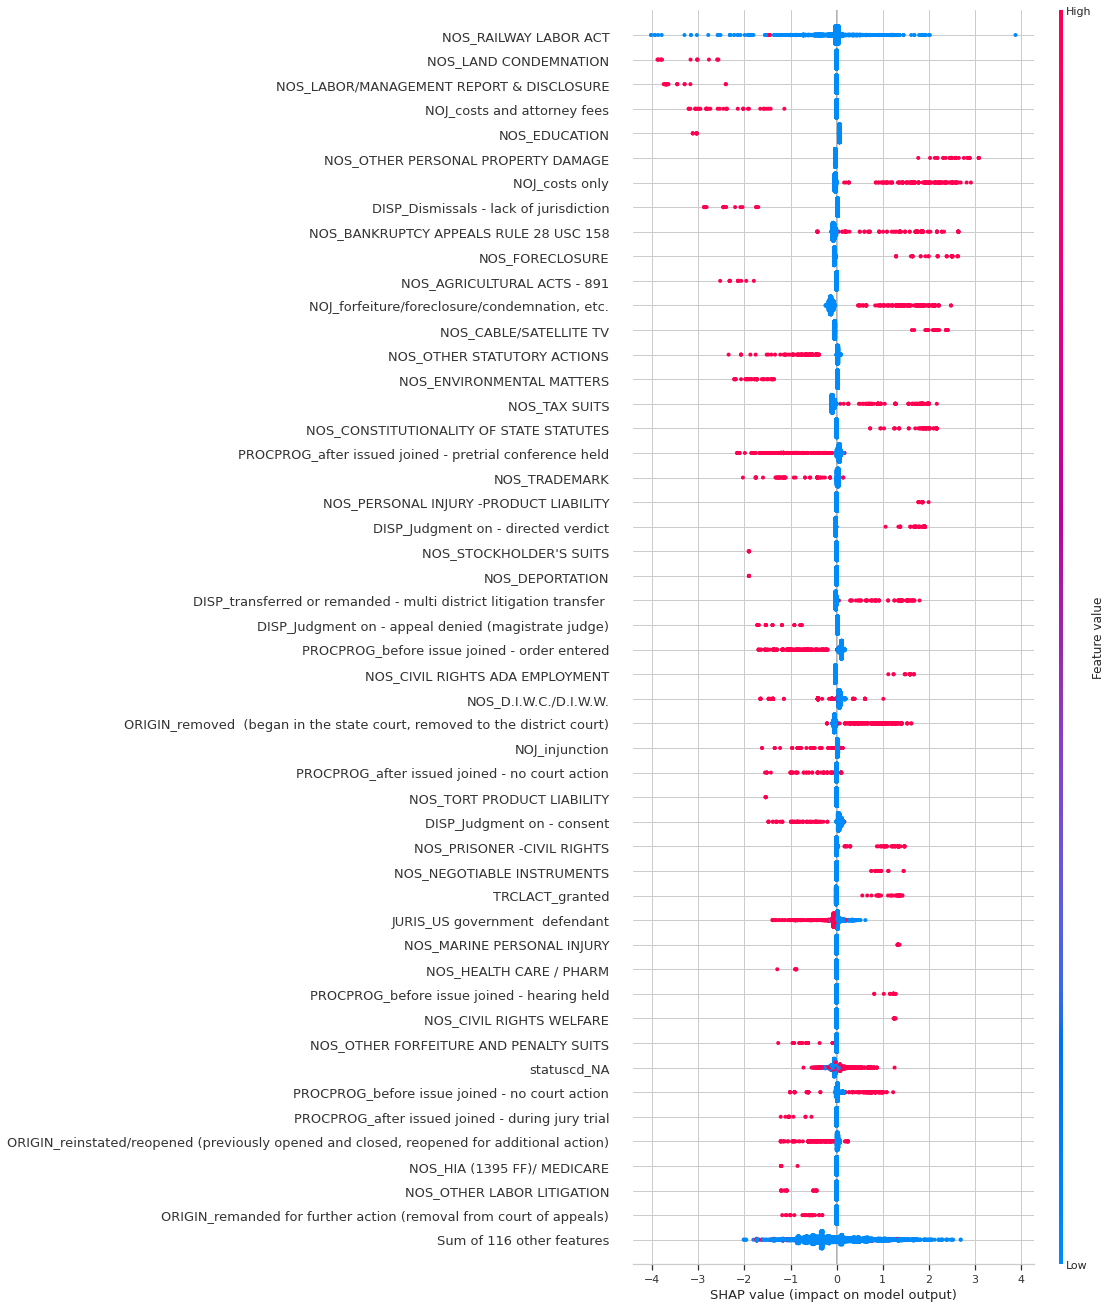

In [55]:
shap.plots.beeswarm(shap_values, order=shap_values.abs.max(0), max_display = 50)